<a href="https://colab.research.google.com/github/Draciger/DracPyTorch/blob/main/MandatoryAssignmentV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
# Importing of libraries & functions
import math
import random
from dataclasses import dataclass
from timeit import default_timer as timer
from typing import Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Reproducibility & device

def set_seed(seed: int = 42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Training-time function

def print_train_time(start, end, device):
    total = end - start
    print(f"\nTrain time on {device}: {total:.2f}s ({total/60:.2f} min)\n")
    return total

# MLP & CNN models

# MLP model
class MLP(nn.Module):
    def __init__(self, in_ch=1, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28 * in_ch, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        return self.net(x)

# CNN model
class TinyCNN(nn.Module):
    def __init__(self, in_ch=1, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 28->14
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 14->7
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128), nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        return self.head(x)

# Early stopping helper

class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, mode="min", restore_best=True):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode  # "min" for loss, "max" for accuracy
        self.best = None
        self.count = 0
        self.restore_best = restore_best
        self.best_state = None

    def is_improved(self, current):
        if self.best is None:
            return True
        if self.mode == "min":
            return current < self.best - self.min_delta
        else:
            return current > self.best + self.min_delta

    def step(self, model: nn.Module, current: float) -> bool:
        """Returns True if we should stop early."""
        if self.is_improved(current):
            self.best = current
            self.count = 0
            if self.restore_best:
                self.best_state = {k: v.detach().cpu().clone()
                                   for k, v in model.state_dict().items()}
            return False
        else:
            self.count += 1
            return self.count > self.patience

    def restore(self, model: nn.Module):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict({k: v.to(DEVICE) for k, v in self.best_state.items()})



# Data: MNIST & Augmentations

def build_transforms(vary: str, name: str) -> Tuple[transforms.Compose, transforms.Compose]:
    base_norm = transforms.Normalize((0.1307,), (0.3081,))
    base_eval = transforms.Compose([transforms.ToTensor(), base_norm])

    if vary != "aug":
        return base_eval, base_eval

    name = (name or "").lower()
    if name == "rotate10":
        aug = transforms.RandomRotation(10)
    elif name == "hflip":
        aug = transforms.RandomHorizontalFlip(p=0.5)
    elif name == "randcrop":
        aug = transforms.RandomCrop(28, padding=3)
    else:
        aug = transforms.RandomRotation(0)

    train_tfms = transforms.Compose([aug, transforms.ToTensor(), base_norm])
    return train_tfms, base_eval


def get_dataloaders(batch_size: int, vary: str, name: str, seed: int = 42):
    set_seed(seed)

    train_tfms, eval_tfms = build_transforms(vary, name)

    full_train = datasets.MNIST(root="./data", train=True, download=True, transform=train_tfms)
    val_full   = datasets.MNIST(root="./data", train=True, download=True, transform=eval_tfms)
    test_ds    = datasets.MNIST(root="./data", train=False, download=True, transform=eval_tfms)

    # split 60k train into 50k/10k
    gen = torch.Generator().manual_seed(seed)
    train_len, val_len = 50_000, 10_000
    train_ds, _ = random_split(full_train, [train_len, len(full_train) - train_len], generator=gen)
    val_ds, _   = random_split(val_full, [val_len, len(val_full) - val_len], generator=gen)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_dl  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_dl, val_dl, test_dl

# Optimizers & Schedulers

def build_optimizer(name: str, model: nn.Module, base_lr: float):
    name = (name or "adam").lower()
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=base_lr, momentum=0.9, weight_decay=5e-4)
    if name == "rmsprop":
        return torch.optim.RMSprop(model.parameters(), lr=base_lr, momentum=0.0)
    return torch.optim.Adam(model.parameters(), lr=base_lr, weight_decay=1e-4)


def build_scheduler(name: str, optimizer: torch.optim.Optimizer, epochs: int):
    name = (name or "").lower()
    if name == "step":
        step_size = max(1, epochs // 3)
        return torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
    if name == "cosine":
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    if name == "plateau":
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=1)
    return None

In [7]:
# Training & Evaluate

# Evaluation model
@torch.no_grad()
def evaluate(model: nn.Module, dl: DataLoader, loss_fn) -> Tuple[float, float]:
    model.eval()
    tot_loss, tot_correct, n = 0.0, 0, 0
    for x, y in dl:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        loss = loss_fn(logits, y)
        tot_loss += loss.item() * y.size(0)
        tot_correct += (logits.argmax(1) == y).sum().item()
        n += y.size(0)
    return tot_loss / n, tot_correct / n

# Training model
def train_model(model: nn.Module,
                train_dl: DataLoader,
                val_dl: DataLoader,
                loss_fn,
                optimizer: torch.optim.Optimizer,
                scheduler=None,
                early_stop: bool = True,
                epochs: int = 10) -> Tuple[Dict, float]:

    model.to(DEVICE)
    es = EarlyStopping(patience=3, min_delta=0.0, mode="min", restore_best=True) if early_stop else None

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

    # Timing start
    train_time_start_model_CNN = timer()

    for ep in range(1, epochs + 1):
        model.train()
        tot_loss, tot_correct, n = 0.0, 0, 0
        for x, y in train_dl:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()

            tot_loss += loss.item() * y.size(0)
            tot_correct += (logits.argmax(1) == y).sum().item()
            n += y.size(0)

        train_loss = tot_loss / n
        train_acc = tot_correct / n

        val_loss, val_acc = evaluate(model, val_dl, loss_fn)

        # Step scheduler
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        lr_now = optimizer.param_groups[0]["nr" if "nr" in optimizer.param_groups[0] else "lr"]

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lr"].append(lr_now)

        print(f"Epoch {ep:02d} | lr {lr_now:.6f} | "
              f"train {train_loss:.4f}/{train_acc*100:.2f}% | "
              f"val {val_loss:.4f}/{val_acc*100:.2f}%")

        if es is not None and es.step(model, val_loss):
            print(f"Early stopping at epoch {ep}")
            break

    if es is not None:
        es.restore(model)

    # Timing
    train_time_end_model_CNN = timer()
    total_train_time_model_CNN = print_train_time(
        start=timer() - (timer() - train_time_start_model_CNN),
        end=train_time_end_model_CNN,
        device=DEVICE,
    )

    return history, total_train_time_model_CNN


In [8]:
# Experiment configuration

@dataclass
class RunCfg:
    # Possible to make configuration when running a experiment
    vary: str             # Choose between: "aug" | "sched" | "opt"
    name: str             # Choose between: #rotate10" | "step" | "adam"
    model_type: str = "cnn"   # "cnn" or "mlp"
    batch_size: int = 128
    epochs: int = 10
    base_lr: float = 1e-3
    seed: int = 42

def make_model(model_type: str) -> nn.Module:
    model_type = (model_type or "cnn").lower()
    if model_type == "mlp":
        return MLP(in_ch=1, num_classes=10)
    return TinyCNN(in_ch=1, num_classes=10)

def run_experiment(cfg: RunCfg) -> Dict:
    print(f"\n=== RUN {cfg.model_type.upper()} | vary={cfg.vary} -> {cfg.name} ===")
    set_seed(cfg.seed)

    # Data (Aug only applied on train if vary=="aug")
    train_dl, val_dl, test_dl = get_dataloaders(cfg.batch_size, cfg.vary, cfg.name, cfg.seed)

    model = make_model(cfg.model_type).to(DEVICE)
    loss_fn = nn.CrossEntropyLoss()

    opt_name = cfg.name if cfg.vary == "opt" else "adam"
    sch_name = cfg.name if cfg.vary == "sched" else None

    optimizer = build_optimizer(opt_name, model, cfg.base_lr)
    scheduler = build_scheduler(sch_name, optimizer, cfg.epochs)

    # Train (with early stopping)
    history, train_time_sec = train_model(
        model, train_dl, val_dl, loss_fn, optimizer, scheduler,
        early_stop=True, epochs=cfg.epochs
    )

    # Final test
    test_loss, test_acc = evaluate(model, test_dl, loss_fn)
    print(f"TEST | loss {test_loss:.4f} | acc {test_acc*100:.2f}%")
    print(f"Total train time (s): {train_time_sec:.2f}")

    return {
        "config": cfg,
        "history": history,
        "train_time_s": train_time_sec,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }


In [13]:
# Running 1 and 1 experiment

run_1 = run_experiment(RunCfg(model_type="cnn", vary="aug", name="rotate10", epochs=10))


=== RUN CNN | vary=aug -> rotate10 ===
Epoch 01 | lr 0.001000 | train 0.2189/92.97% | val 0.0594/98.23%
Epoch 02 | lr 0.001000 | train 0.0588/98.15% | val 0.0306/99.01%
Epoch 03 | lr 0.001000 | train 0.0447/98.63% | val 0.0299/98.91%
Epoch 04 | lr 0.001000 | train 0.0366/98.83% | val 0.0251/99.31%
Epoch 05 | lr 0.001000 | train 0.0304/99.08% | val 0.0190/99.42%
Epoch 06 | lr 0.001000 | train 0.0285/99.04% | val 0.0172/99.51%
Epoch 07 | lr 0.001000 | train 0.0232/99.26% | val 0.0195/99.50%
Epoch 08 | lr 0.001000 | train 0.0221/99.30% | val 0.0195/99.34%
Epoch 09 | lr 0.001000 | train 0.0211/99.32% | val 0.0089/99.73%
Epoch 10 | lr 0.001000 | train 0.0191/99.35% | val 0.0113/99.62%

Train time on cpu: 1281.33s (21.36 min)

TEST | loss 0.0193 | acc 99.40%
Total train time (s): 1281.33


In [14]:
run_2 = run_experiment(RunCfg(model_type="cnn", vary="aug", name="hflip",   epochs=10))


=== RUN CNN | vary=aug -> hflip ===
Epoch 01 | lr 0.001000 | train 0.3164/89.60% | val 0.1001/96.92%
Epoch 02 | lr 0.001000 | train 0.0867/97.30% | val 0.0858/97.50%
Epoch 03 | lr 0.001000 | train 0.0646/97.97% | val 0.0453/98.62%
Epoch 04 | lr 0.001000 | train 0.0485/98.49% | val 0.0374/98.89%
Epoch 05 | lr 0.001000 | train 0.0425/98.65% | val 0.0251/99.34%
Epoch 06 | lr 0.001000 | train 0.0353/98.85% | val 0.0346/98.89%
Epoch 07 | lr 0.001000 | train 0.0332/98.93% | val 0.0273/99.21%
Epoch 08 | lr 0.001000 | train 0.0281/99.10% | val 0.0361/98.82%
Epoch 09 | lr 0.001000 | train 0.0252/99.22% | val 0.0239/99.25%
Epoch 10 | lr 0.001000 | train 0.0240/99.24% | val 0.0272/99.05%

Train time on cpu: 1249.32s (20.82 min)

TEST | loss 0.0482 | acc 98.56%
Total train time (s): 1249.32


In [15]:
run_3 = run_experiment(RunCfg(model_type="cnn", vary="aug", name="randcrop",epochs=10))


=== RUN CNN | vary=aug -> randcrop ===
Epoch 01 | lr 0.001000 | train 0.3204/89.54% | val 0.0934/96.89%
Epoch 02 | lr 0.001000 | train 0.0842/97.37% | val 0.0580/98.20%
Epoch 03 | lr 0.001000 | train 0.0579/98.22% | val 0.0317/99.04%
Epoch 04 | lr 0.001000 | train 0.0503/98.48% | val 0.0369/98.96%
Epoch 05 | lr 0.001000 | train 0.0431/98.66% | val 0.0326/99.12%
Epoch 06 | lr 0.001000 | train 0.0366/98.91% | val 0.0268/99.03%
Epoch 07 | lr 0.001000 | train 0.0336/98.96% | val 0.0306/99.14%
Epoch 08 | lr 0.001000 | train 0.0306/99.06% | val 0.0328/98.87%
Epoch 09 | lr 0.001000 | train 0.0295/99.07% | val 0.0198/99.43%
Epoch 10 | lr 0.001000 | train 0.0270/99.18% | val 0.0142/99.55%

Train time on cpu: 1253.37s (20.89 min)

TEST | loss 0.0171 | acc 99.49%
Total train time (s): 1253.37


In [16]:
run_4 = run_experiment(RunCfg(model_type="cnn", vary="sched", name="step", epochs=10))


=== RUN CNN | vary=sched -> step ===
Epoch 01 | lr 0.001000 | train 0.1974/93.69% | val 0.0760/97.42%
Epoch 02 | lr 0.001000 | train 0.0484/98.50% | val 0.0296/99.10%
Epoch 03 | lr 0.000500 | train 0.0328/98.99% | val 0.0240/99.20%
Epoch 04 | lr 0.000500 | train 0.0168/99.47% | val 0.0130/99.59%
Epoch 05 | lr 0.000500 | train 0.0124/99.61% | val 0.0149/99.53%
Epoch 06 | lr 0.000250 | train 0.0120/99.61% | val 0.0091/99.69%
Epoch 07 | lr 0.000250 | train 0.0051/99.87% | val 0.0062/99.83%
Epoch 08 | lr 0.000250 | train 0.0036/99.90% | val 0.0038/99.91%
Epoch 09 | lr 0.000125 | train 0.0042/99.89% | val 0.0054/99.86%
Epoch 10 | lr 0.000125 | train 0.0017/99.96% | val 0.0026/99.94%

Train time on cpu: 1260.94s (21.02 min)

TEST | loss 0.0272 | acc 99.26%
Total train time (s): 1260.94


In [17]:
run_5 = run_experiment(RunCfg(model_type="cnn", vary="sched", name="cosine", epochs=10))


=== RUN CNN | vary=sched -> cosine ===
Epoch 01 | lr 0.000976 | train 0.1974/93.69% | val 0.0760/97.42%
Epoch 02 | lr 0.000905 | train 0.0478/98.50% | val 0.0308/99.11%
Epoch 03 | lr 0.000794 | train 0.0318/99.00% | val 0.0238/99.29%
Epoch 04 | lr 0.000655 | train 0.0227/99.27% | val 0.0147/99.55%
Epoch 05 | lr 0.000500 | train 0.0151/99.52% | val 0.0124/99.60%
Epoch 06 | lr 0.000345 | train 0.0099/99.70% | val 0.0100/99.65%
Epoch 07 | lr 0.000206 | train 0.0055/99.85% | val 0.0077/99.77%
Epoch 08 | lr 0.000095 | train 0.0031/99.91% | val 0.0037/99.91%
Epoch 09 | lr 0.000024 | train 0.0015/99.97% | val 0.0033/99.93%
Epoch 10 | lr 0.000000 | train 0.0009/99.98% | val 0.0033/99.93%

Train time on cpu: 1272.59s (21.21 min)

TEST | loss 0.0262 | acc 99.26%
Total train time (s): 1272.59


In [18]:
run_6 = run_experiment(RunCfg(model_type="cnn", vary="sched", name="plateau", epochs=10))


=== RUN CNN | vary=sched -> plateau ===
Epoch 01 | lr 0.001000 | train 0.1974/93.69% | val 0.0760/97.42%
Epoch 02 | lr 0.001000 | train 0.0484/98.50% | val 0.0296/99.10%
Epoch 03 | lr 0.001000 | train 0.0328/98.99% | val 0.0240/99.20%
Epoch 04 | lr 0.001000 | train 0.0255/99.19% | val 0.0166/99.52%
Epoch 05 | lr 0.001000 | train 0.0204/99.33% | val 0.0167/99.45%
Epoch 06 | lr 0.001000 | train 0.0174/99.46% | val 0.0130/99.66%
Epoch 07 | lr 0.001000 | train 0.0149/99.51% | val 0.0134/99.56%
Epoch 08 | lr 0.000500 | train 0.0122/99.59% | val 0.0215/99.27%
Epoch 09 | lr 0.000500 | train 0.0058/99.84% | val 0.0045/99.89%
Epoch 10 | lr 0.000500 | train 0.0021/99.94% | val 0.0037/99.91%

Train time on cpu: 1399.92s (23.33 min)

TEST | loss 0.0263 | acc 99.27%
Total train time (s): 1399.92


In [19]:
run_7 = run_experiment(RunCfg(model_type="cnn", vary="opt", name="sgd", epochs=10, base_lr=1e-2))


=== RUN CNN | vary=opt -> sgd ===
Epoch 01 | lr 0.010000 | train 0.6999/77.85% | val 0.1075/96.41%
Epoch 02 | lr 0.010000 | train 0.0761/97.64% | val 0.0580/98.22%
Epoch 03 | lr 0.010000 | train 0.0510/98.41% | val 0.0428/98.87%
Epoch 04 | lr 0.010000 | train 0.0386/98.78% | val 0.0282/99.15%
Epoch 05 | lr 0.010000 | train 0.0315/99.01% | val 0.0320/99.03%
Epoch 06 | lr 0.010000 | train 0.0266/99.16% | val 0.0215/99.40%
Epoch 07 | lr 0.010000 | train 0.0222/99.27% | val 0.0200/99.46%
Epoch 08 | lr 0.010000 | train 0.0190/99.34% | val 0.0152/99.62%
Epoch 09 | lr 0.010000 | train 0.0166/99.48% | val 0.0156/99.61%
Epoch 10 | lr 0.010000 | train 0.0124/99.64% | val 0.0124/99.68%

Train time on cpu: 1368.59s (22.81 min)

TEST | loss 0.0307 | acc 99.09%
Total train time (s): 1368.59


In [20]:
run_8 = run_experiment(RunCfg(model_type="cnn", vary="opt", name="adam", epochs=10, base_lr=1e-3))


=== RUN CNN | vary=opt -> adam ===
Epoch 01 | lr 0.001000 | train 0.1974/93.69% | val 0.0760/97.42%
Epoch 02 | lr 0.001000 | train 0.0484/98.50% | val 0.0296/99.10%
Epoch 03 | lr 0.001000 | train 0.0328/98.99% | val 0.0240/99.20%
Epoch 04 | lr 0.001000 | train 0.0255/99.19% | val 0.0166/99.52%
Epoch 05 | lr 0.001000 | train 0.0204/99.33% | val 0.0167/99.45%
Epoch 06 | lr 0.001000 | train 0.0174/99.46% | val 0.0130/99.66%
Epoch 07 | lr 0.001000 | train 0.0149/99.51% | val 0.0134/99.56%
Epoch 08 | lr 0.001000 | train 0.0122/99.59% | val 0.0215/99.27%
Epoch 09 | lr 0.001000 | train 0.0127/99.59% | val 0.0108/99.63%
Epoch 10 | lr 0.001000 | train 0.0107/99.65% | val 0.0071/99.74%

Train time on cpu: 1382.73s (23.05 min)

TEST | loss 0.0280 | acc 99.27%
Total train time (s): 1382.73


In [21]:
run_9 = run_experiment(RunCfg(model_type="cnn", vary="opt", name="rmsprop", epochs=10, base_lr=1e-3))


=== RUN CNN | vary=opt -> rmsprop ===
Epoch 01 | lr 0.001000 | train 0.2512/92.19% | val 0.0700/97.76%
Epoch 02 | lr 0.001000 | train 0.0498/98.45% | val 0.0355/98.82%
Epoch 03 | lr 0.001000 | train 0.0334/98.90% | val 0.0258/99.23%
Epoch 04 | lr 0.001000 | train 0.0237/99.25% | val 0.0166/99.57%
Epoch 05 | lr 0.001000 | train 0.0175/99.41% | val 0.0182/99.36%
Epoch 06 | lr 0.001000 | train 0.0139/99.51% | val 0.0103/99.71%
Epoch 07 | lr 0.001000 | train 0.0100/99.68% | val 0.0325/99.08%
Epoch 08 | lr 0.001000 | train 0.0088/99.69% | val 0.0138/99.60%
Epoch 09 | lr 0.001000 | train 0.0082/99.74% | val 0.0085/99.72%
Epoch 10 | lr 0.001000 | train 0.0072/99.77% | val 0.0085/99.73%

Train time on cpu: 1338.16s (22.30 min)

TEST | loss 0.0231 | acc 99.28%
Total train time (s): 1338.16


In [22]:
torch.save(run_1, "run_1_rotate10.pt")
torch.save(run_2, "run_2_hflip.pt")
torch.save(run_3, "run_3_randcrop.pt")
torch.save(run_4, "run_4_step.pt")
torch.save(run_5, "run_5_cosine.pt")
torch.save(run_6, "run_6_plateau.pt")
torch.save(run_7, "run_7_sgd.pt")
torch.save(run_8, "run_8_adam.pt")
torch.save(run_9, "run_9_rmsprop.pt")

In [34]:
# Making a table, that shows different information

import os
import torch
import numpy as np
import pandas as pd
from dataclasses import is_dataclass, asdict

RESULTS_DIR = "."

def load_run(filepath):
    return torch.load(os.path.join(RESULTS_DIR, filepath),
                      map_location="cpu", weights_only=False)

def to_config_dict(cfg_obj):
    if cfg_obj is None:
        return {}
    if isinstance(cfg_obj, dict):
        return cfg_obj
    if is_dataclass(cfg_obj):
        return asdict(cfg_obj)
    # Generic object with attributes
    keys = ("vary", "name", "model_type", "epochs", "seed", "base_lr")
    return {k: getattr(cfg_obj, k) for k in keys if hasattr(cfg_obj, k)}

def build_summary(files):
    rows = []
    for fp in files:
        d = load_run(fp)

        # Config may be a RunCfg object
        cfg = to_config_dict(d.get("config", {}))
        hist = d.get("history", {})

        # Best-of validation (if present)
        val_loss = hist.get("val_loss", [])
        val_acc  = hist.get("val_acc", [])
        if isinstance(val_loss, (list, tuple)) and len(val_loss) > 0:
            vloss = [float(x) for x in val_loss]
            best_idx = int(np.argmin(vloss))
            epochs_vec = hist.get("epoch", list(range(1, len(vloss)+1)))
            best_epoch = int(epochs_vec[best_idx]) if len(epochs_vec) == len(vloss) else (best_idx + 1)
            best_val_loss = float(vloss[best_idx])
            if isinstance(val_acc, (list, tuple)) and len(val_acc) == len(vloss):
                best_val_acc = float(val_acc[best_idx])
            else:
                best_val_acc = np.nan
        else:
            best_epoch, best_val_loss, best_val_acc = np.nan, np.nan, np.nan

        rows.append({
            "vary": cfg.get("vary", ""),
            "name": cfg.get("name", os.path.splitext(fp)[0]),
            "file": os.path.basename(fp),
            "epochs_trained": len(hist.get("train_loss", [])),
            "best_epoch": best_epoch,
            "best_val_loss": best_val_loss,
            "best_val_acc": best_val_acc,
            "final_test_loss": float(d.get("test_loss", float("nan"))),
            "final_test_acc":  float(d.get("test_acc",  float("nan"))),
            "train_time_s":    float(d.get("train_time_s", float("nan"))),
        })
    return pd.DataFrame(rows)

# A table, showing different info about the 9 experiments.

files = [
    "run_1_rotate10.pt",
    "run_2_hflip.pt",
    "run_3_randcrop.pt",
    "run_4_step.pt",
    "run_5_cosine.pt",
    "run_6_plateau.pt",
    "run_7_sgd.pt",
    "run_8_adam.pt",
    "run_9_rmsprop.pt",
]

summary_df_clean = build_summary(files).sort_values("final_test_acc", ascending=False).reset_index(drop=True)
summary_df_clean["run_id"] = range(1, len(summary_df_clean) + 1)
summary_df_clean

,vary,name,file,epochs_trained,best_epoch,best_val_loss,best_val_acc,final_test_loss,final_test_acc,train_time_s,run_id
0,aug,randcrop,run_3_randcrop.pt,10,10,0.014237,0.9955,0.017113,0.9949,1253.368510,1
1,aug,rotate10,run_1_rotate10.pt,10,9,0.008880,0.9973,0.019254,0.9940,1281.330339,2
2,opt,rmsprop,run_9_rmsprop.pt,10,9,0.008474,0.9972,0.023128,0.9928,1338.160237,3
3,sched,plateau,run_6_plateau.pt,10,10,0.003730,0.9991,0.026279,0.9927,1399.915239,4
4,opt,adam,run_8_adam.pt,10,10,0.007102,0.9974,0.028002,0.9927,1382.734923,5
5,sched,step,run_4_step.pt,10,10,0.002563,0.9994,0.027207,0.9926,1260.939352,6
6,sched,cosine,run_5_cosine.pt,10,10,0.003261,0.9993,0.026209,0.9926,1272.590589,7
7,opt,sgd,run_7_sgd.pt,10,10,0.012385,0.9968,0.030734,0.9909,1368.590846,8
8,aug,hflip,run_2_hflip.pt,10,9,0.023936,0.9925,0.048175,0.9856,1249.324659,9


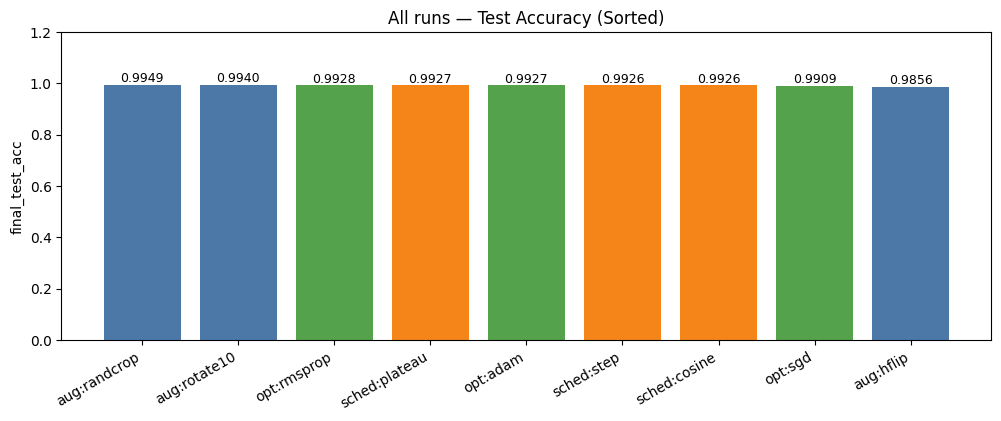

In [32]:
# A bar plot showing the accuracy results of the different experiements

def plot_overall_bars(df, metric="final_test_acc", color_by="vary", title=None):
    df2 = df.copy().sort_values(metric, ascending=('loss' in metric))
    labels = df2.apply(lambda r: f"{r['vary']}:{r['name']}", axis=1)
    colors = df2[color_by].map({"aug":"#4C78A8", "sched":"#F58518", "opt":"#54A24B"})

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.bar(labels, df2[metric], color=colors)
    ax.set_ylim(0.0, 1.2 if 'acc' in metric else None)
    ax.set_ylabel(metric)
    ax.set_title(title or f"{metric} (sorted)")

    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=30, ha="right")

    for i, v in enumerate(df2[metric].values):
        ax.text(i, v, f"{v:.4f}" if 'acc' in metric else f"{v:.5f}",
                ha="center", va="bottom", fontsize=9)
    plt.show()

plot_overall_bars(df_summary, "final_test_acc", title="All runs — Test Accuracy (Sorted)")


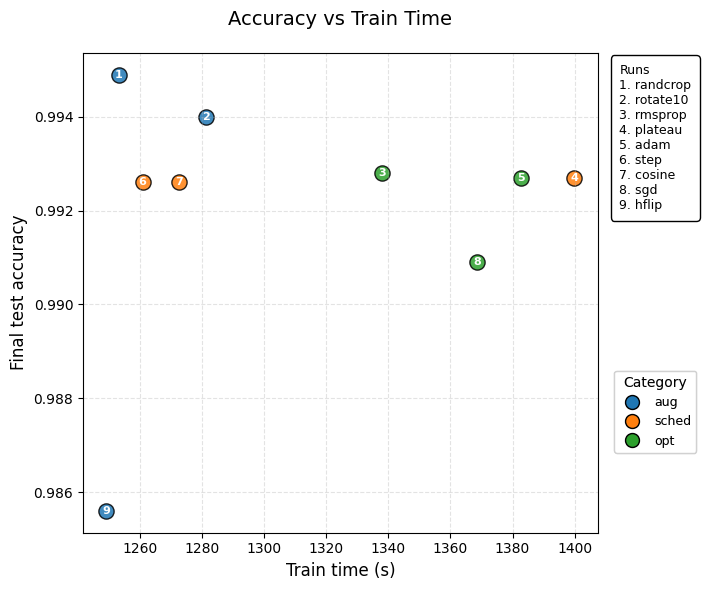

In [29]:
# Efficiency plot - That shows accuracy and training time combined for the different experiments

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

# Reset and ensure run IDs
summary_df_clean = summary_df_clean.reset_index(drop=True).copy()
summary_df_clean["run_id"] = range(1, len(summary_df_clean) + 1)

colors = {"aug": "#1f77b4", "sched": "#ff7f0e", "opt": "#2ca02c"}

fig, ax = plt.subplots(figsize=(9, 6))

# Scatter with numbered dots
for cat, color in colors.items():
    sub = summary_df_clean[summary_df_clean["vary"] == cat]
    ax.scatter(sub["train_time_s"], sub["final_test_acc"],
               s=120, color=color, alpha=0.85, edgecolor='k')
    for _, row in sub.iterrows():
        ax.text(row["train_time_s"], row["final_test_acc"],
                str(row["run_id"]),
                ha="center", va="center",
                color="white", fontsize=8, fontweight="bold")

# Runs Legend
run_lines = [f"{rid}. {nm}" for rid, nm in zip(summary_df_clean["run_id"], summary_df_clean["name"])]
mapping_text = "Runs\n" + "\n".join(run_lines)

at = AnchoredText(mapping_text, prop=dict(size=9), frameon=True, loc='upper left')
at.patch.set_boxstyle("round,pad=0.3")
ax.add_artist(at)
at.set_bbox_to_anchor((1.02, 1), transform=ax.transAxes)

# Category legend
cat_handles = [
    Line2D([0], [0], marker='o', color='w',
           markerfacecolor=colors[k], markeredgecolor='k',
           markersize=10, label=k)
    for k in ["aug", "sched", "opt"]
]

leg1 = ax.legend(
    handles=cat_handles,
    title="Category",
    bbox_to_anchor=(1.02, 0.35),
    loc='upper left',
    frameon=True,
    fontsize=9
)
ax.add_artist(leg1)

# Labels, title, grid
ax.set_title("Accuracy vs Train Time", fontsize=14, pad=20)
ax.set_xlabel("Train time (s)", fontsize=12)
ax.set_ylabel("Final test accuracy", fontsize=12)
ax.grid(True, linestyle="--", alpha=0.35)


plt.tight_layout(rect=[0, 0, 0.8, 1])
plt.show()


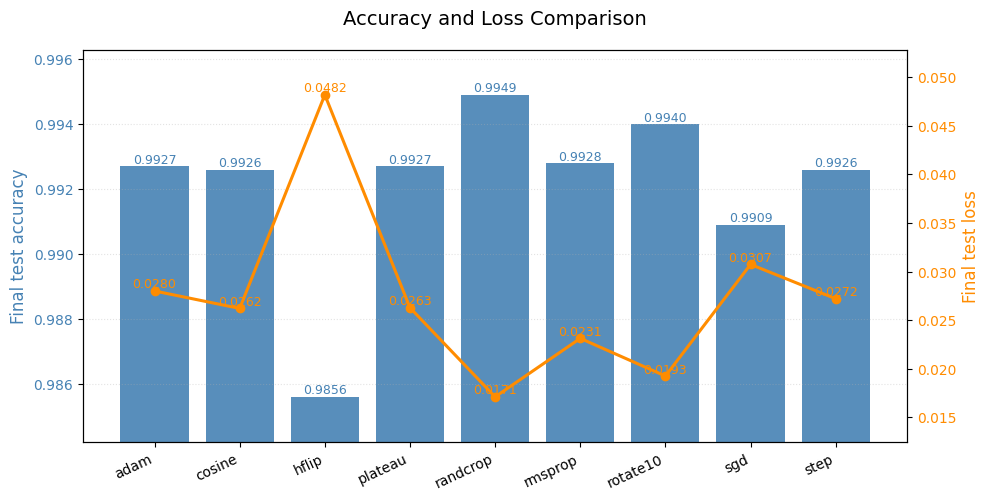

In [33]:
# A model that shows accuracy and loss comparison

def plot_acc_loss_comparison(df):
    # Order by name
    df = df.sort_values('name').reset_index(drop=True)
    names = df['name'].tolist()
    acc   = df['final_test_acc'].to_numpy()
    loss  = df['final_test_loss'].to_numpy()

    # Tight y-limits so differences are visible
    acc_min, acc_max = acc.min(), acc.max()
    loss_min, loss_max = loss.min(), loss.max()
    acc_pad  = max(0.0003, 0.15 * (acc_max - acc_min))
    loss_pad = max(0.0003, 0.15 * (loss_max - loss_min))

    x = np.arange(len(names))

    plt.style.use('default')
    fig, ax1 = plt.subplots(figsize=(10, 5.5))

    # Accuracy (left axis) — bars
    bars = ax1.bar(x, acc, color='steelblue', alpha=0.9, label='Accuracy')
    ax1.set_ylabel('Final test accuracy', color='steelblue', fontsize=12)
    ax1.set_ylim(acc_min - acc_pad, acc_max + acc_pad)
    ax1.tick_params(axis='y', labelcolor='steelblue')

    # Loss (right axis) — line
    ax2 = ax1.twinx()
    ax2.plot(x, loss, color='darkorange', marker='o', linewidth=2.2, label='Loss')
    ax2.set_ylabel('Final test loss', color='darkorange', fontsize=12)
    ax2.set_ylim(loss_min - loss_pad, loss_max + loss_pad)
    ax2.tick_params(axis='y', labelcolor='darkorange')

    # X ticks and labels
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=25, ha='right')

    # Title
    ax1.set_title('Accuracy and Loss Comparison', fontsize=14, pad=18)

    # Value labels
    for b in bars:
        y = b.get_height()
        ax1.text(b.get_x() + b.get_width()/2, y, f'{y:.4f}',
                 ha='center', va='bottom', fontsize=9, color='steelblue')
    for xi, y in zip(x, loss):
        ax2.text(xi, y, f'{y:.4f}', ha='center', va='bottom',
                 fontsize=9, color='darkorange')

    ax1.grid(axis='y', linestyle=':', alpha=0.35)

    fig.tight_layout(rect=[0, 0, 1, 0.93])

    plt.show()
    return fig, ax1, ax2

# Use it:
fig, ax1, ax2 = plot_acc_loss_comparison(summary_df_clean)
